# Описание задачи  
  
Smartys - сервис анализа видеопотока с целью распознавания и идентификации лиц. Одной из прикладных задач является работа с распознаванием лиц, а также обработкой embedding-ов этих лиц.  
В данном задании вам необходимо выбрать оптимальный порог меры близости embedding-ов для идентификации лиц одного человека.  
  
## Входные данные   
В директории находится два файла: train.tsv (обучающая выборка), test.tsv (тестовая выборка) одного формата.Каждая строка файла содержит два embedding-а и признак того, принадлежат ли они одному человеку.  
  
>**В файле три колонки:**  
>embedding_x - (string) конкатенация факторов embedding-а одного лица. (Объединенные через символ “,”).  
>embedding_y - (string) конкатенация факторов embedding-а другого лица. (Объединенные через символ “,”).  
>equal - бинарный признак того, что embedding_x и emedding_y принадлежат одному человеку.  
  
На обучающей выборке необходимо посчитать меру близости между embedding_x и embedding_y, на основании полученных близостей выбрать оптимальный threshold для распознавания embedding-ов одного человека (случай когда equal=1), на тестовой выборке провести валидацию подбора threshold-a.  
  
## Требования к выходным данным   
В качестве результата необходим на выбор: Jupyter Notebook, python script содержащий ход решения задания, а также аргументацию подбора threshold-a.  
  
>**Требования к реализации:**  
>Реализацию требуется произвести на Python 3.7  
>Решение требуется загрузить на github репозиторий.  
>Мера близости embedding-ов выбирается произвольно.   

In [303]:
import pandas as pd
import numpy as np
import face_recognition

from sklearn.metrics import confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

***
Импортируем данные.
***

In [88]:
df = pd.read_csv('./train.tsv', sep='\t')
df.head()

,embedding_x,embedding_y,equal
0,"0.35198048,0.23884374,0.20589112,0.033522803,0...","0.124149986,0.14133812,0.16054663,0.38359353,0...",1
1,"0.3492841,-0.18005244,0.46332806,-0.2122336,0....","-0.7460901,-0.21427503,-0.14653064,-0.22343078...",0
2,"0.5642844,-0.08399645,-0.018092873,0.18461637,...","-0.30552676,0.10498648,0.40437204,0.25560898,-...",0
3,"0.36132073,-0.20658037,0.4909494,0.12876663,0....","0.25936005,-0.15755327,0.4929783,-0.11315008,0...",1
4,"-0.039740197,-0.11732757,-0.07907649,0.1649697...","0.26061502,-0.31516105,-0.04165541,0.16747917,...",1


In [349]:
df['equal'].value_counts()

1    7837
0    7748
Name: equal, dtype: int64

***
Видим, что примерно половина лиц - действительно те лица, с которыми мы их будем сравнивать.  
Самый простой вариант, проставить везде единицы, уже даст нам 50% аккуратности предсказаний, значит меньше 3500 true positive/true negative значений нас не устроят.     
  
Еще, нам не сказано, ошибка какого рода нам более важна:  
- более точно определять совпадения (например, если ни разу не предсказать совпадение, мы не ошибемся в нем :));  
- либо находить как можно больше истинных совпадений (то есть, ставим все значения как единица и не упускаем ни одного истинного совпадения);  

Поэтому будем стараться достигать баланса в этих метриках.  
***
Сейчас данные у нас в виде строк. Для алгоритма, сравнивающего embedding'и лиц - это должны быть ndarray'и. Делаем пару преобразований.
***

In [89]:
def transform_into_embedding(vector):
    embedding = vector.split(',')
    embedding = list(map(float, embedding))
    embedding = np.array(embedding).reshape(1, 128)
    return embedding

In [517]:
df_t = df.copy()
df_t['embedding_x'] = pd.Series(map(transform_into_embedding, df['embedding_x']))
df_t['embedding_y'] = pd.Series(map(transform_into_embedding, df['embedding_y']))
df_t.head()

,embedding_x,embedding_y,equal
0,"[[0.35198048, 0.23884374, 0.20589112, 0.033522...","[[0.124149986, 0.14133812, 0.16054663, 0.38359...",1
1,"[[0.3492841, -0.18005244, 0.46332806, -0.21223...","[[-0.7460901, -0.21427503, -0.14653064, -0.223...",0
2,"[[0.5642844, -0.08399645, -0.018092873, 0.1846...","[[-0.30552676, 0.10498648, 0.40437204, 0.25560...",0
3,"[[0.36132073, -0.20658037, 0.4909494, 0.128766...","[[0.25936005, -0.15755327, 0.4929783, -0.11315...",1
4,"[[-0.039740197, -0.11732757, -0.07907649, 0.16...","[[0.26061502, -0.31516105, -0.04165541, 0.1674...",1


***
Теперь я создам новую колонку в датафрейме, в которой будут списки c 10 бинарными значениями  
Если лицо совпадает - ставится 1, если нет - 0.  
  
В списке 10 значений, потому что перебирается значение `tolerance`. Для начала я попробую значения от 0.1 до 1 включительно.  
Первое значение в списке получено с `tolerance = 0.1`, последнее с `tolerance = 1`.
***

In [518]:
def evaluate_tolerance(embedding_x, embedding_y, min=0.1, max=1):
    '''
    Receives: two face embeddings
    Calculates if the faces are similar with 
    '''
    results = []
    for n in np.round(np.linspace(min, max, 10), 3):
        result = face_recognition.compare_faces(embedding_x, embedding_y, tolerance=n)
        results.append(result[0])
    return list(map(int, results))

In [519]:
%%time
df_t['tolerance_results'] = pd.Series(map(evaluate_tolerance, df_t['embedding_x'], df_t['embedding_y']))

CPU times: user 2.36 s, sys: 74.4 ms, total: 2.43 s
Wall time: 2.16 s


***
Я получил списки совпадения для каждой пары лиц. Теперь я хочу посмотреть метрики по разным значениям `tolerance`.  
  
Для этого мне нужно сделать вместо одной колонки в датафрейме (как есть сейчас) - ndarray (матрицу) и взять по отдельности каждую ее колонку, для замеров метрик.
***

In [520]:
arr = np.stack(df_t['tolerance_results'].values)

for i, tol in enumerate(np.arange(0.1, 1.1, 0.1)): 
    df_t[f'tolerance {tol:.3f}'] = arr[:,i]

***
Теперь наш датафрейм выглядит так:
***

In [521]:
df_t.head()

,embedding_x,embedding_y,equal,tolerance_results,tolerance 0.100,tolerance 0.200,tolerance 0.300,tolerance 0.400,tolerance 0.500,tolerance 0.600,tolerance 0.700,tolerance 0.800,tolerance 0.900,tolerance 1.000
0,"[[0.35198048, 0.23884374, 0.20589112, 0.033522...","[[0.124149986, 0.14133812, 0.16054663, 0.38359...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]",0,0,0,0,0,0,0,0,0,1
1,"[[0.3492841, -0.18005244, 0.46332806, -0.21223...","[[-0.7460901, -0.21427503, -0.14653064, -0.223...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0,0,0,0,0,0,0,0,0
2,"[[0.5642844, -0.08399645, -0.018092873, 0.1846...","[[-0.30552676, 0.10498648, 0.40437204, 0.25560...",0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0,0,0,0,0,0,0,0,0
3,"[[0.36132073, -0.20658037, 0.4909494, 0.128766...","[[0.25936005, -0.15755327, 0.4929783, -0.11315...",1,"[0, 0, 0, 0, 0, 0, 1, 1, 1, 1]",0,0,0,0,0,0,1,1,1,1
4,"[[-0.039740197, -0.11732757, -0.07907649, 0.16...","[[0.26061502, -0.31516105, -0.04165541, 0.1674...",1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0,0,0,0,0,0,0,0,0


***
Создаю функцию для удобства подсчета метрик.
***

In [522]:
def evaluate_metrics(df, min=0.1, max=1):
    total_evaluation = [['tolerance coefficient', '(tn, fp, fn, tp)', 'precision', 'recall', 'roc_auc_score']]
    for tol in np.round(np.linspace(min, max, 10), 3):
        evaluation = [f'tolerance={tol:.3f}',]
        tn, fp, fn, tp = confusion_matrix(df['equal'], df[f'tolerance {tol:.3f}']).ravel()
        evaluation.append((tn, fp, fn, tp))
        evaluation.append(tp / (tp + fp)) # precision
        evaluation.append(tp / (tp + fn)) # recall
        evaluation.append(roc_auc_score(df['equal'], df[f'tolerance {tol:.3f}'])) #roc_auc
        total_evaluation.append(evaluation)
    return total_evaluation

In [523]:
total_results = evaluate_metrics(df_t)

***
Графики результатов:
***

In [552]:
def show_metrics_plot(results, min=0.1, max=1):
    plt.figure(figsize=(16, 16))

    x = np.round(np.linspace(min, max, 10), 3)

    plt.subplot(221)
    plt.plot(x, np.array(results)[1:,2])
    plt.ylabel('precision')
    plt.xlabel('tolerance coefficient')

    plt.subplot(222)
    plt.plot(x, np.array(results)[1:,3])
    plt.ylabel('recall')
    plt.xlabel('tolerance coefficient')

    plt.subplot(223)
    plt.plot(x, np.array(results)[1:,4])
    plt.ylabel('roc_auc')
    plt.xlabel('tolerance coefficient')

    plt.show()

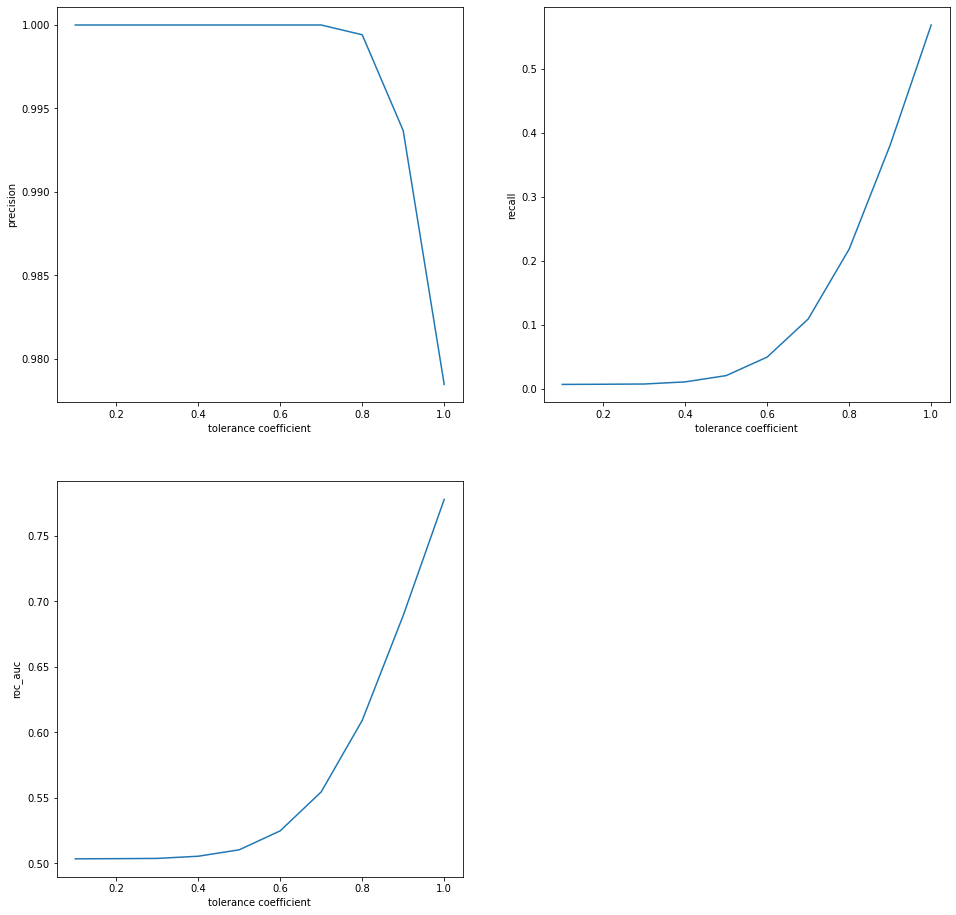

In [525]:
show_metrics_plot(total_results)

In [526]:
np.array(total_results)[:,:2]

array([['tolerance coefficient', '(tn, fp, fn, tp)'],
       ['tolerance=0.100', (7748, 0, 7782, 55)],
       ['tolerance=0.200', (7748, 0, 7780, 57)],
       ['tolerance=0.300', (7748, 0, 7777, 60)],
       ['tolerance=0.400', (7748, 0, 7751, 86)],
       ['tolerance=0.500', (7748, 0, 7674, 163)],
       ['tolerance=0.600', (7748, 0, 7447, 390)],
       ['tolerance=0.700', (7748, 0, 6981, 856)],
       ['tolerance=0.800', (7747, 1, 6125, 1712)],
       ['tolerance=0.900', (7729, 19, 4852, 2985)],
       ['tolerance=1.000', (7650, 98, 3383, 4454)]], dtype=object)

***
По первым результатам видим, что `tolerance < 0.8` бесполезен, так как у нас отвратительный показатель `recall` (полнота).  
  
Так получается, потому что при низком `tolerance` алгоритм из 15 000 сравнений только 50 раз показывает нам совпадение в лицах (это можно увидеть на матрицах ошибок чуть выше, смотрим значение tp).  
  
Чем больше мы ставим параметр `tolerance`, тем больше совпадений модель начинает определять, и тем чаще она начинает в них ошибаться (это видно по увеличению кол-ва fp значений и увеличению tp значений).  
  
Однако с этими данными, алгоритм все равно ошибается очень редко, так что `tolerance = 1`, выглядит как хороший вариант.
***
Не останавливаемся на достигнутом, пробуем значения `tolerance > 1`, повторяя все шаги выше.
***

In [527]:
%%time
df_t['tolerance_results_new'] = \
pd.Series(map(lambda x, y: evaluate_tolerance(x, y, min=1.1, max=2.1), *[df_t['embedding_x'], df_t['embedding_y']]))

CPU times: user 2.47 s, sys: 89.3 ms, total: 2.56 s
Wall time: 2.16 s


In [528]:
arr = np.stack(df_t['tolerance_results_new'].values)

for i, tol in enumerate(np.round(np.linspace(1.1, 2, 10), 1)): 
    df_t[f'tolerance {tol:.3f}'] = arr[:,i]

In [532]:
df_t[['equal', 'tolerance 1.100',
      'tolerance 1.200', 'tolerance 1.300', 'tolerance 1.400',
      'tolerance 1.500', 'tolerance 1.600', 'tolerance 1.700',
      'tolerance 1.800', 'tolerance 1.900', 'tolerance 2.000']].head()

,equal,tolerance 1.100,tolerance 1.200,tolerance 1.300,tolerance 1.400,tolerance 1.500,tolerance 1.600,tolerance 1.700,tolerance 1.800,tolerance 1.900,tolerance 2.000
0,1,1,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,1,1,1,1,1
2,0,0,0,0,0,0,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,1


In [533]:
total_results_new = evaluate_metrics(df_t, min=1.1, max=2)

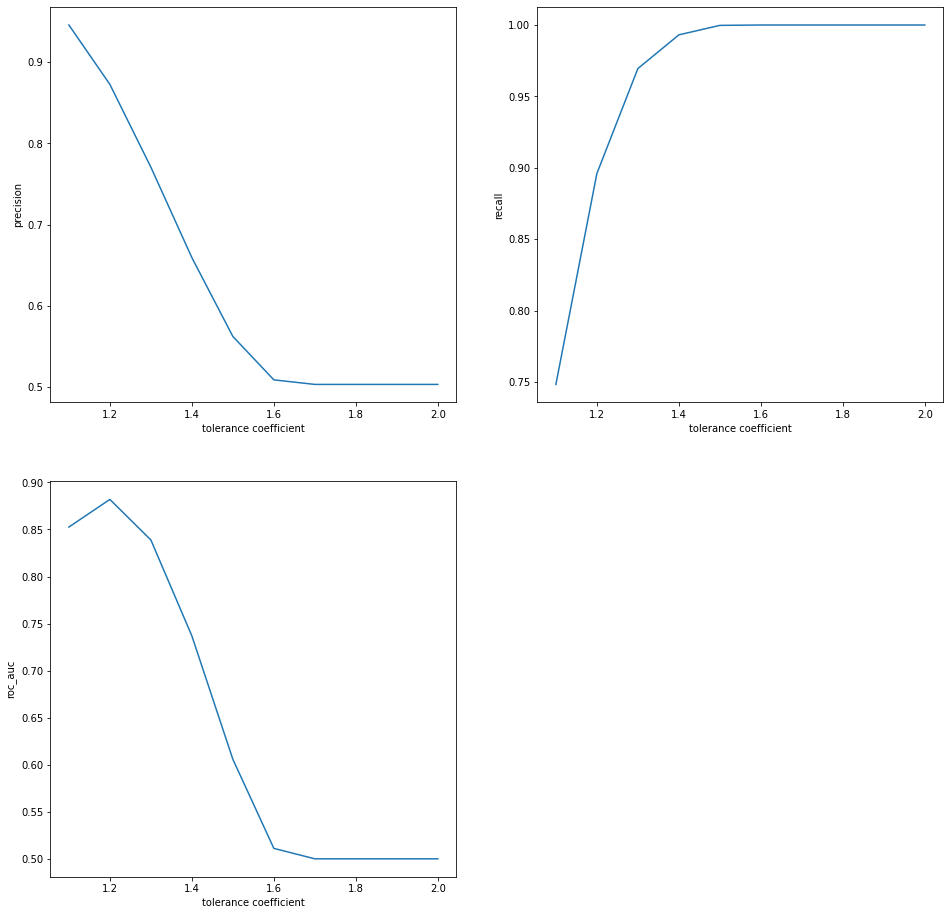

In [534]:
show_metrics_plot(total_results_new, min=1.1, max=2)

In [535]:
np.array(total_results_new)[:,:2]

array([['tolerance coefficient', '(tn, fp, fn, tp)'],
       ['tolerance=1.100', (7413, 335, 1972, 5865)],
       ['tolerance=1.200', (6724, 1024, 815, 7022)],
       ['tolerance=1.300', (5487, 2261, 239, 7598)],
       ['tolerance=1.400', (3724, 4024, 54, 7783)],
       ['tolerance=1.500', (1641, 6107, 2, 7835)],
       ['tolerance=1.600', (172, 7576, 0, 7837)],
       ['tolerance=1.700', (0, 7748, 0, 7837)],
       ['tolerance=1.800', (0, 7748, 0, 7837)],
       ['tolerance=1.900', (0, 7748, 0, 7837)],
       ['tolerance=2.000', (0, 7748, 0, 7837)]], dtype=object)

In [536]:
np.array(total_results_new)[:3,:]

array([['tolerance coefficient', '(tn, fp, fn, tp)', 'precision',
        'recall', 'roc_auc_score'],
       ['tolerance=1.100', (7413, 335, 1972, 5865), 0.9459677419354838,
        0.7483731019522777, 0.8525680687871867],
       ['tolerance=1.200', (6724, 1024, 815, 7022), 0.8727317921948794,
        0.8960061247926503, 0.881921492959051]], dtype=object)

***
Теперь я попробовал значения `1 < tolerance < 2`. На матрицах ошибок видим, что при `tolerance >= 1.6` алгоритм начал на каждую пару лиц проставлять совпадение.  
Это наш второй крайний случай, когда максимизируется recall (полнота).  
***
**При `tolerance = 1.2`** алгоритм предсказал примерно одинаковое кол-во совпадений/разностей.  
**Метрики при этом составили:**
- `precision = 0.88`
- `recall = 0.88`
- `roc_auc = 0.88`
***
Попробуем еще более детально прогнать все значения на промежутке `1.1 < tolerancce < 1.3`.

In [537]:
%%time
df_t['tolerance_results_completely_new'] = \
pd.Series(map(lambda x, y: evaluate_tolerance(x, y, min=1.1, max=1.3), *[df_t['embedding_x'], df_t['embedding_y']]))

CPU times: user 2.41 s, sys: 85.4 ms, total: 2.49 s
Wall time: 2.13 s


In [538]:
arr = np.stack(df_t['tolerance_results_completely_new'].values)

for i, tol in enumerate(np.round(np.linspace(1.1, 1.3, 10), 3)): 
    df_t[f'tolerance {tol:.3f}'] = arr[:,i]

In [542]:
df_t[['equal', 'tolerance 1.122',
      'tolerance 1.144', 'tolerance 1.167', 'tolerance 1.189',
      'tolerance 1.211', 'tolerance 1.233', 'tolerance 1.256',
      'tolerance 1.278']].head()

,equal,tolerance 1.122,tolerance 1.144,tolerance 1.167,tolerance 1.189,tolerance 1.211,tolerance 1.233,tolerance 1.256,tolerance 1.278
0,1,1,1,1,1,1,1,1,1
1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1


In [543]:
total_results_completely_new = evaluate_metrics(df_t, min=1.1, max=1.3)

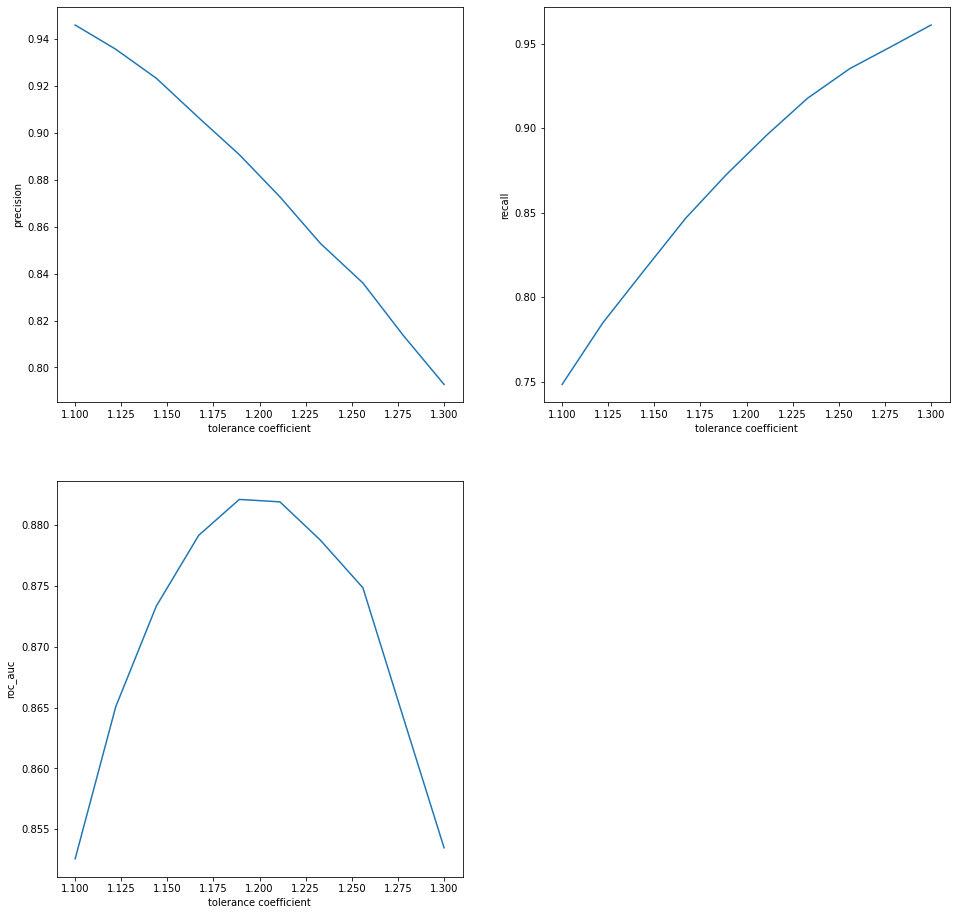

In [553]:
show_metrics_plot(total_results_completely_new, min=1.1, max=1.3)

In [547]:
np.array(total_results_completely_new)[:,:2]

array([['tolerance coefficient', '(tn, fp, fn, tp)'],
       ['tolerance=1.100', (7413, 335, 1972, 5865)],
       ['tolerance=1.122', (7325, 423, 1687, 6150)],
       ['tolerance=1.144', (7217, 531, 1448, 6389)],
       ['tolerance=1.167', (7063, 685, 1201, 6636)],
       ['tolerance=1.189', (6909, 839, 999, 6838)],
       ['tolerance=1.211', (6724, 1024, 815, 7022)],
       ['tolerance=1.233', (6507, 1241, 645, 7192)],
       ['tolerance=1.256', (6310, 1438, 507, 7330)],
       ['tolerance=1.278', (6045, 1703, 407, 7430)],
       ['tolerance=1.300', (5779, 1969, 305, 7532)]], dtype=object)

In [551]:
np.array(total_results_completely_new)[:,2:5]

array([['precision', 'recall', 'roc_auc_score'],
       [0.9459677419354838, 0.7483731019522777, 0.8525680687871867],
       [0.9356458238247376, 0.7847390583131301, 0.8650721620940973],
       [0.9232658959537572, 0.815235421717494, 0.8733508032696916],
       [0.9064335473295998, 0.8467525838968993, 0.8791713358307418],
       [0.8907125179106422, 0.8725277529666965, 0.8821208718369878],
       [0.8727317921948794, 0.8960061247926503, 0.881921492959051],
       [0.8528400332028934, 0.9176980987622815, 0.8787638661080379],
       [0.8359945255474452, 0.9353068776317468, 0.8748552973600139],
       [0.8135333406328699, 0.9480668623197652, 0.8641341023008222],
       [0.7927586569834755, 0.961082046701544, 0.8534759743058572]],
      dtype=object)

***
При более детальном рассмотрении видно, что по всей видимости, нет смысла перебирать значения `tolerance` настолько точно.  
Вполне хватило точности до одной десятой.  
***
**Теперь проверяем качество подобранного параметра на тестовых данных.**  
***

In [556]:
df_test = pd.read_csv('./test.tsv', sep='\t')
df_test.head()

,embedding_x,embedding_y,equal
0,"0.297163,-0.19147852,0.514213,0.11966697,0.220...","0.33785084,-0.16910027,-0.1574438,-0.023615347...",0
1,"0.28278404,-0.21183152,0.3420205,-0.23023371,0...","0.297163,-0.19147852,0.514213,0.11966697,0.220...",1
2,"0.50050944,-0.07608504,0.1397811,0.17560016,0....","0.40801406,0.10747076,0.3100398,0.040430743,0....",1
3,"0.18524958,-0.23291345,0.47159392,0.21318983,0...","-0.04595025,-0.4184819,-0.3319743,-0.18005435,...",1
4,"0.3160543,-0.12296223,0.27941337,0.27271396,0....","0.40801406,0.10747076,0.3100398,0.040430743,0....",1


In [557]:
df_test['equal'].value_counts()

0    976
1    973
Name: equal, dtype: int64

In [ ]:
df_test['embedding_x'] = pd.Series(map(transform_into_embedding, df_test['embedding_x']))
df_test['embedding_y'] = pd.Series(map(transform_into_embedding, df_test['embedding_y']))

In [563]:
%%time
df_test['predictions'] = \
pd.Series(map(lambda x, y: int(face_recognition.compare_faces(x, y, tolerance=1.2)[0]), *[df_test['embedding_x'], df_test['embedding_y']]))

CPU times: user 42.5 ms, sys: 0 ns, total: 42.5 ms
Wall time: 40.3 ms


In [564]:
df_test.head()

,embedding_x,embedding_y,equal,predictions
0,"[[0.297163, -0.19147852, 0.514213, 0.11966697,...","[[0.33785084, -0.16910027, -0.1574438, -0.0236...",0,0
1,"[[0.28278404, -0.21183152, 0.3420205, -0.23023...","[[0.297163, -0.19147852, 0.514213, 0.11966697,...",1,1
2,"[[0.50050944, -0.07608504, 0.1397811, 0.175600...","[[0.40801406, 0.10747076, 0.3100398, 0.0404307...",1,1
3,"[[0.18524958, -0.23291345, 0.47159392, 0.21318...","[[-0.04595025, -0.4184819, -0.3319743, -0.1800...",1,0
4,"[[0.3160543, -0.12296223, 0.27941337, 0.272713...","[[0.40801406, 0.10747076, 0.3100398, 0.0404307...",1,1


In [566]:
total_evaluation = [['tolerance coefficient', '(tn, fp, fn, tp)', 'precision', 'recall', 'roc_auc_score']]
evaluation = ['tolerance 1.2',]

tn, fp, fn, tp = confusion_matrix(df_test['equal'], df_test['predictions']).ravel()
evaluation.append((tn, fp, fn, tp))
evaluation.append(tp / (tp + fp)) # precision
evaluation.append(tp / (tp + fn)) # recall
evaluation.append(roc_auc_score(df_test['equal'], df_test['predictions'])) #roc_auc

total_evaluation.append(evaluation)

In [567]:
np.array(total_evaluation)[:,:2]

array([['tolerance coefficient', '(tn, fp, fn, tp)'],
       ['tolerance 1.2', (873, 103, 107, 866)]], dtype=object)

In [569]:
np.array(total_evaluation)[:,2:5]

array([['precision', 'recall', 'roc_auc_score'],
       [0.8937048503611971, 0.8900308324768756, 0.892249022795815]],
      dtype=object)

## Выводы:
По тренировочным данным, получилось достигнуть баланса в `precision/recall` при значении `tolerance = 1.2`.  
При этом значении, алгоритм правильно определяет 7022 сходств в лицах, 6724 разностей и ошибается в сумме 1839 раз.  
  
**Аккуратность/точность алгоритма состовляет:**  
100 - ((1839 / (7837 + 7748)) * 100) = 88.2%  
  
При этом кол-во ошибок первого и второго рода примерно одинаковое. Если у нас будет задача или информация о том, какую ошибку нужно минимизировать - уже будет просто разобраться, уменьшаем мы `tolerance` или увеличиваем.  
  
На тестовых данных `tolerance = 1.2` показал результаты даже чуть лучше, что не удивительно, так как данные ничем не отличаются от тренировочных.  
  
Тем более, алгоритм, который используется для сравнения лиц - не нуждается в обучении, он всего навсего считает дистанцию между ввекторами, а наш параметр `tolerance` указывает ему, при какой максимальной дистанции, алгоритм скажет нам, что лица совпадают.  
  
Поэтому разбиение на `train/test` тут не повлияло бы ни на что.